<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2020/blob/master/day-05/MLDM_2020_seminar05_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [1]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [2]:
class FeatureSelector:
    def __init__(self, num_features):
        self.n = num_features # number of best features to select

    def fit(self, X, y):
        # Select features that describe the targets best, i.e. have
        # highest correlation with them:
        covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
        self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

    def transform(self, X):
        return X[:,self.best_feature_ids]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [3]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.95


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

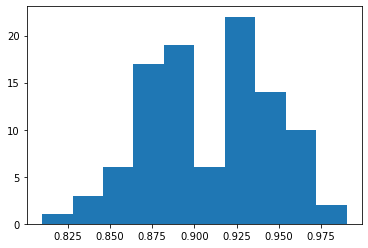

In [4]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
    # Dataset generation
    X = np.random.normal(size=(N, num_features_total))
    y = np.random.randint(2, size=N)

    # Feature selection:
    X_best = FeatureSelector(num_features_best).fit_transform(X, y)

    # Simple classification model
    model = LinearSVC()

    # Estimatin accuracy using cross-validation:
    return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (6 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem.

*Hint: the problem is in the overall logic, and not a bug in the code.*

## Reason for high accuracy when cross validation is done
This is primarily due to data leakage in which feature selection had been done before crossvalidation. In essence we combined test and training sets and based on the entire dataset 
we are finding the highest correlated variables with our response variable. Feature selection should be exposed only to training information.

## Proof that the model is not as accurate

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Feature selection:
X_best_train = FeatureSelector(num_features_best).fit_transform(X_train, y_train)
X_best_test = FeatureSelector(num_features_best).fit_transform(X_test, y_test)

# Simple classification model
model = LinearSVC()

model.fit(X_best_train, y_train)
# Estimatin accuracy using cross-validation:
accuracy = model.score(X_best_test, y_test)
print(f"Accuracy of model after train_test split: {accuracy}")

Accuracy of model after train_test split: 0.6


## Cross-validation done right
Since the dataset is not as much let's do cross-validation the right way

In [8]:
kfold = KFold(n_splits=10)

total_accuracy = []
for index, value in enumerate(kfold.split(X)):
    train_index, test_index = value
    # Feature selection:
    X_best_train = FeatureSelector(num_features_best).fit_transform(X_train, y_train)
    X_best_test = FeatureSelector(num_features_best).fit_transform(X_test, y_test)

    # Simple classification model
    model = LinearSVC()

    model.fit(X_best_train, y_train)
    # Estimatin accuracy using cross-validation:
    accuracy = model.score(X_best_test, y_test)
    print(f"Accuracy for fold no {index}: {accuracy}")
    total_accuracy.append(accuracy)

Accuracy for fold no 0: 0.6
Accuracy for fold no 1: 0.6
Accuracy for fold no 2: 0.6
Accuracy for fold no 3: 0.6
Accuracy for fold no 4: 0.6
Accuracy for fold no 5: 0.6
Accuracy for fold no 6: 0.6
Accuracy for fold no 7: 0.6
Accuracy for fold no 8: 0.6
Accuracy for fold no 9: 0.6


In [9]:
f"Average accuracy of model {sum(total_accuracy)/len(total_accuracy)}"

'Average accuracy of model 0.5999999999999999'

In [10]:
from sklearn.pipeline import make_pipeline

# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = make_pipeline(
    FeatureSelector(num_features_best),
    LinearSVC()
) 
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f, Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.580, Standard Deviation: (0.178)


## The accuracy seems to change after each run